## Simple Diffusion

#### Import required libraries and functions

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from IPython.display import display, clear_output, HTML
from matplotlib.animation import FuncAnimation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Flatten,
    Input,
    MaxPool2D,
    Reshape,
    UpSampling2D,
)
from tqdm.auto import tqdm

#### Set a fixed seed to reproduce results

In [2]:
seed = 1337
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use("fivethirtyeight")

#### Setup parameters for training

In [3]:
img_shape = (28, 28, 1)
train_size = 4096
batch_size = 128
time_steps = 25
epochs = 5
learning_rate = 5e-4
weight_decay = 1e-6
log_steps = 10

#### Helper functions

- `display_samples`: Display a list of MNIST samples
- `display_noise_timesteps_for_sample`: Display an MNIST sample with noise added over time
- `plot_video`: Creates a video showing addition of noise to MNIST samples
- `plot_sample_generation`: Creates a video showing the denoising steps using diffusion
- `add_noise`: Helper function to add noise to a sample

In [4]:
def display_samples(samples):
    count = samples.shape[0]
    plt_size = int(np.ceil(count**0.5))

    fig, axes = plt.subplots(plt_size, plt_size, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(count):
        ax = axes[i]
        ax.imshow(samples[i], cmap="Greys")
        ax.axis("off")

    fig.suptitle("MNIST Digits", fontsize=32)
    plt.tight_layout()
    plt.show()


def display_noise_timesteps_for_sample(sample, time):
    sample = tf.reshape(sample, (1, *img_shape))
    noisy_samples = add_noise(tf.repeat(sample, time_steps, axis=0), time)
    display_samples(noisy_samples.numpy())


def plot_video(generation_count: int, time_steps: int):
    def update_plot(i, samples):
        clear_output(wait=True)

        plt_size = int(np.ceil(generation_count**0.5))
        fig, axes = plt.subplots(plt_size, plt_size, figsize=(12, 8))
        axes = axes.flatten()

        ts = np.array([i / time_steps])

        for j in range(generation_count):
            noisy_sample = add_noise(samples[j], ts).numpy().reshape(28, 28, 1)
            ax = axes[j]
            ax.imshow(noisy_sample, cmap="Greys")
            ax.axis("off")

        fig.suptitle(f"Image at Time Step {i}", fontsize=32)
        plt.tight_layout()
        plt.show()

    animation = FuncAnimation(
        plt.gcf(),
        update_plot,
        frames=range(0, time_steps, 1),
        fargs=(x_train[:generation_count].numpy(),),
    )
    _ = animation.to_html5_video()


def plot_sample_generation(samples):
    def update_plot(i):
        clear_output(wait=True)

        plt_size = int(np.ceil(samples.shape[1] ** 0.5))
        fig, axes = plt.subplots(plt_size, plt_size, figsize=(12, 8))
        axes = axes.flatten()

        for index, sample in enumerate(samples[i]):
            ax = axes[index]
            ax.imshow(sample, cmap="Greys")
            ax.axis("off")

        fig.suptitle(f"Sample Generation Step {i}")
        plt.tight_layout()
        plt.show()

    animation = FuncAnimation(
        plt.gcf(),
        update_plot,
        frames=range(samples.shape[0]),
    )
    _ = animation.to_html5_video()


def add_noise(x, t):
    noise = np.random.normal(size=x.shape)
    amount = tf.reshape(t, (-1, 1, 1, 1))
    return (1 - amount) * x + amount * noise

#### Training Data

Training data is loaded and normalized. A dataset loader is also created to iterate over batches while training.

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, *img_shape))
x_test = x_test.reshape((-1, *img_shape))
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32) / 255.0
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32) / 255.0

merged_dataset = tf.concat([x_train, x_test], axis=0)
merged_dataset = tf.random.shuffle(merged_dataset)
merged_dataset = merged_dataset[:train_size]

train_loader = (
    tf.data.Dataset.from_tensor_slices(merged_dataset).shuffle(1024).batch(batch_size)
)

#### Visualization

Plot of MNIST samples before adding noise

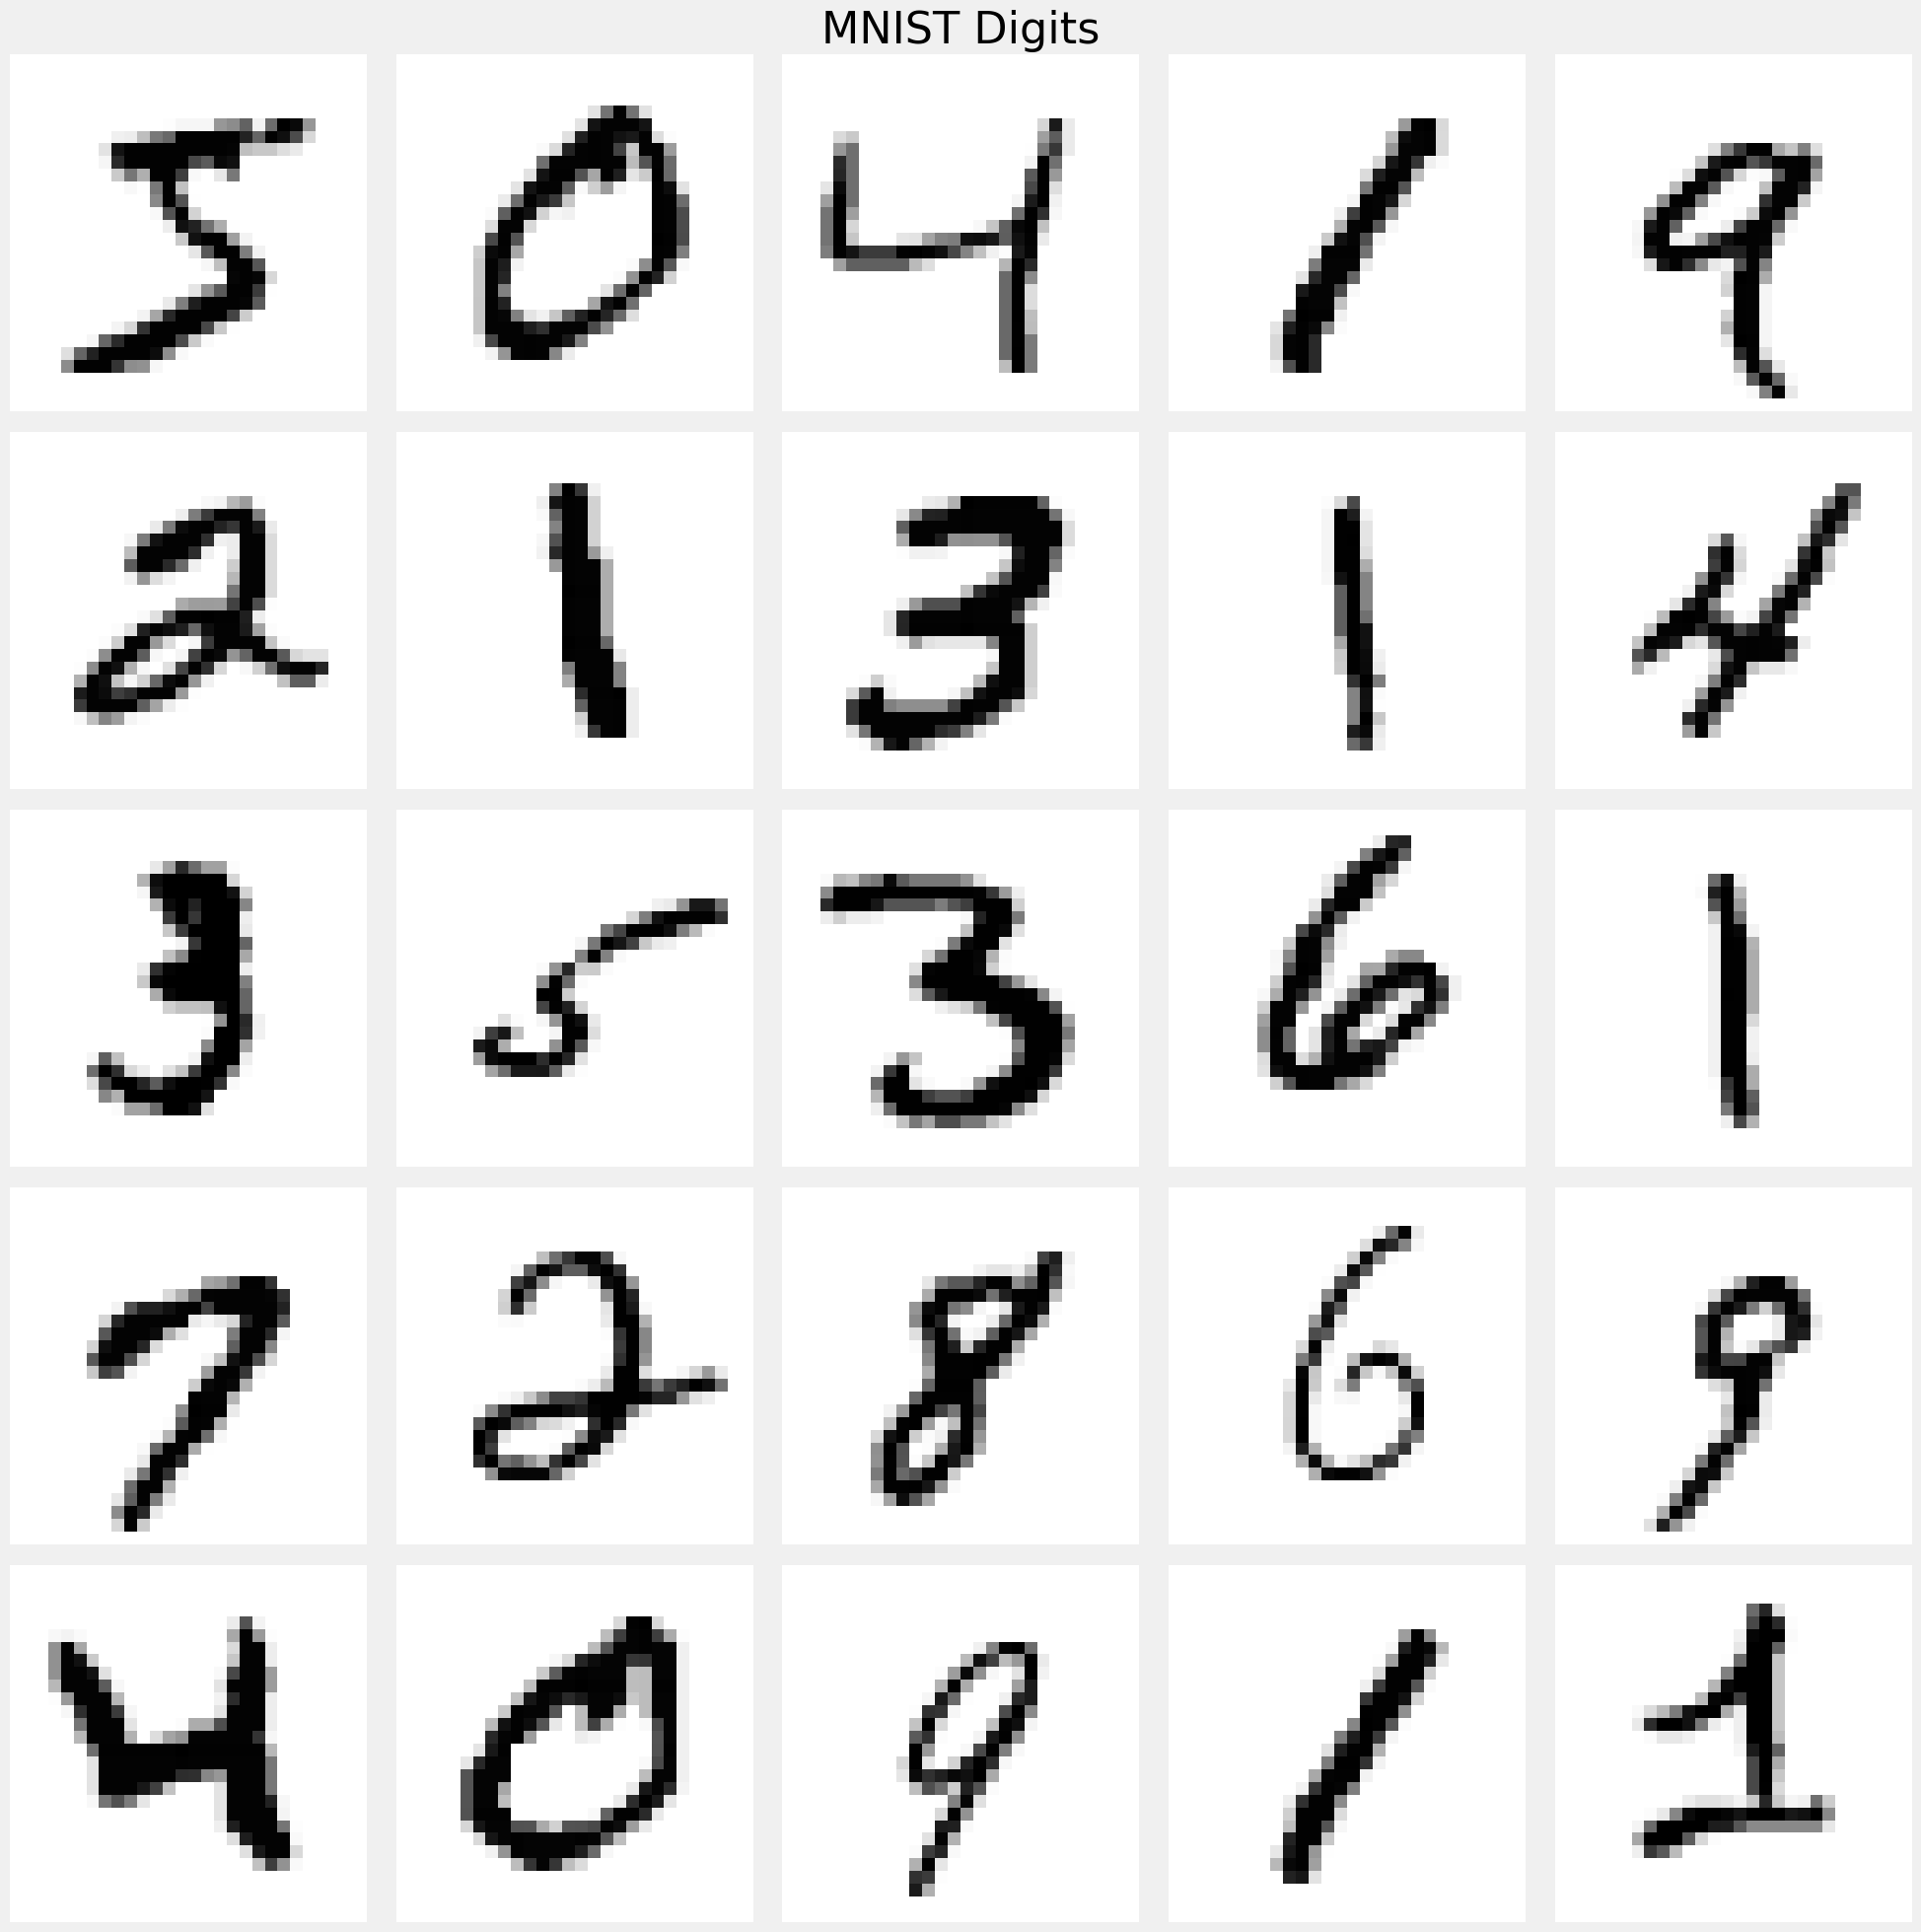

In [6]:
display_samples(x_train[:25].numpy())

Plot of adding noise to a single sample over time

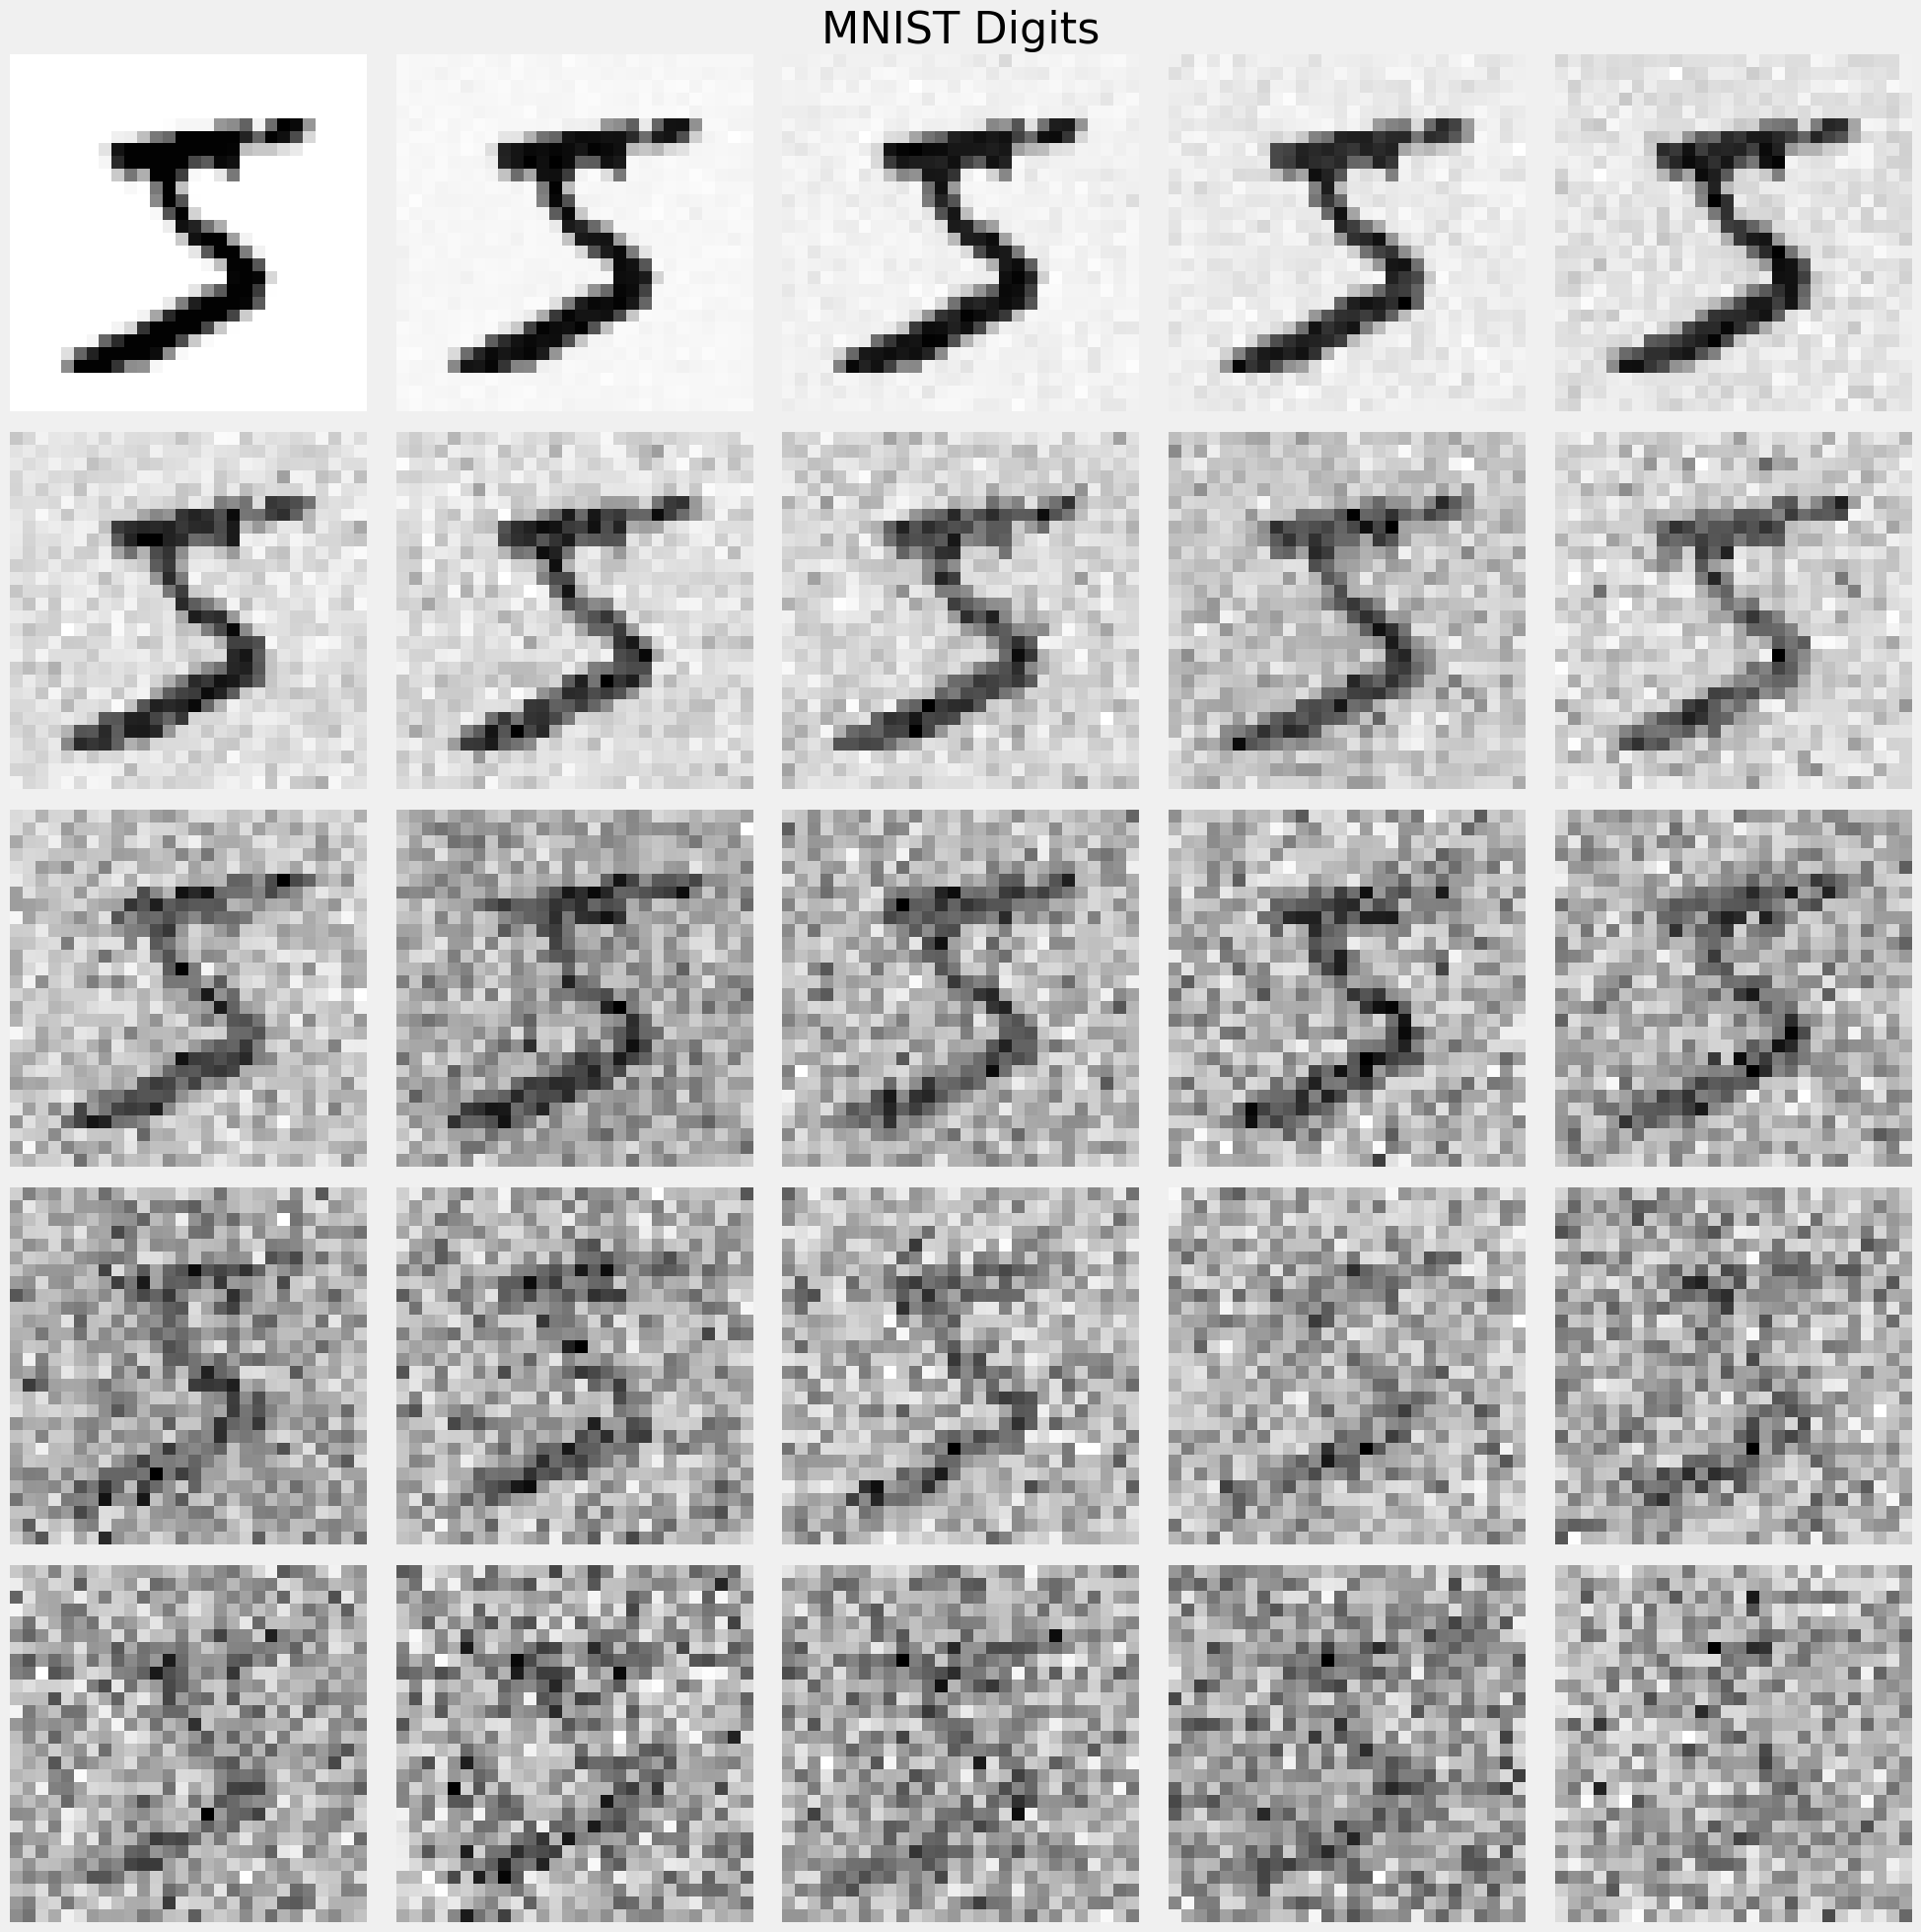

In [7]:
display_noise_timesteps_for_sample(x_train[0], tf.linspace(0.0, 0.5, time_steps))

Video of noise addition process to different samples over time

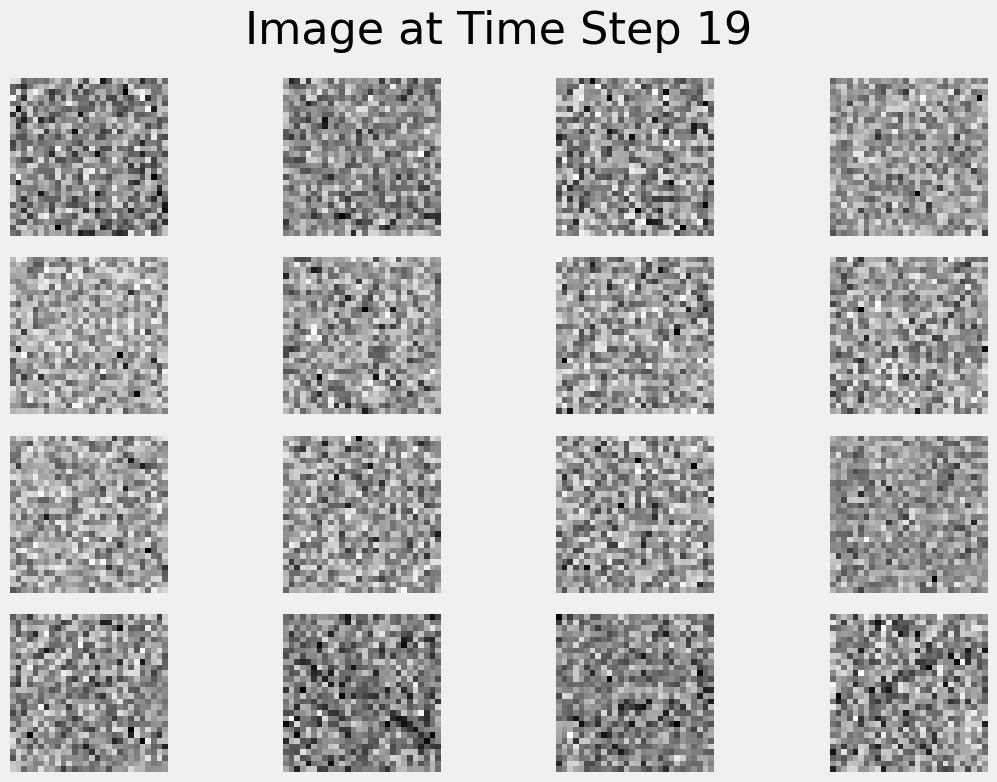

In [8]:
plot_video(generation_count=16, time_steps=20)

#### Model

We use a simple UNet model that has three downsampling layers and three upsampling layers.

I've noticed that adding skip connections does not seem to work very well in this model. Theoretically, they don't really _need_ to improve models per se, but do help solve vanishing gradients in very deep models. Maybe the reason it doesn't work well here is that we are using a shallow NN and possibly just overcomplicating the feature space that the model needs to learn.

In [9]:
def block(filters: int):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(filters, kernel_size=5, padding="same"),
            tf.keras.layers.ReLU(),
        ]
    )


class SimpleUNet(tf.keras.Model):
    def __init__(self) -> None:
        super(SimpleUNet, self).__init__()

        self.down = [block(32), block(64), block(64)]
        self.up = [block(64), block(32), block(1)]
        self.downsample = tf.keras.layers.MaxPool2D()
        self.upsample = tf.keras.layers.UpSampling2D(size=2)

    def call(self, x):
        skip_connections = []

        for index, layer in enumerate(self.down):
            x = layer(x)
            if index + 1 < len(self.down):
                skip_connections.append(x)
                x = self.downsample(x)

        for index, layer in enumerate(self.up):
            if index > 0:
                x = self.upsample(x)
                # x += skip_connections.pop()
            x = layer(x)

        return x

Define the loss and optimizer and build the model

In [10]:
model = SimpleUNet()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [11]:
model.build(input_shape=(None, *img_shape))
model.compile(optimizer=optimizer, loss=loss)
model.summary(expand_nested=True)

Model: "simple_u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 32)        832       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)           (None, 28, 28, 32)        832       |
|                                                               |
| re_lu (ReLU)              (None, 28, 28, 32)        0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_1 (Sequential)   (None, 14, 14, 64)        51264     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_1 (Conv2D)         (None, 14, 14, 64)        51264     |
|                                                               |
| re_lu_1 (ReLU)            (None, 14, 14, 64)        0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_2 (Sequential)   (None, 7, 7, 64)         

#### Training

The model is trained for a fixed number of epochs over all batches of input. Each time, the input is shuffled, and random linearized noise (in the range 0.0 to 0.5) is added. This is not the best way to add noise, but for understanding diffusion purposes, this is fine. Normally, you would use something like Gaussian noise.

In [12]:
losses = []
total_steps = 0

for epoch in range(epochs):
    for step, x_batch in enumerate(train_loader):
        x_batch = tf.random.shuffle(x_batch)
        noise = tf.linspace(0.0, 0.5, x_batch.shape[0])
        noisy_x_batch = add_noise(x_batch, noise)
        loss_val = model.train_on_batch(noisy_x_batch, x_batch)
        losses.append(loss_val)

        if total_steps % log_steps == 0:
            print(f"Epoch: {epoch}, Loss: {loss_val:.4f}")

        total_steps += 1

Epoch: 0, Loss: 0.0943
Epoch: 0, Loss: 0.0616
Epoch: 0, Loss: 0.0478
Epoch: 0, Loss: 0.0345
Epoch: 1, Loss: 0.0308
Epoch: 1, Loss: 0.0261
Epoch: 1, Loss: 0.0237
Epoch: 2, Loss: 0.0234
Epoch: 2, Loss: 0.0203
Epoch: 2, Loss: 0.0201
Epoch: 3, Loss: 0.0192
Epoch: 3, Loss: 0.0183
Epoch: 3, Loss: 0.0180
Epoch: 4, Loss: 0.0169
Epoch: 4, Loss: 0.0158
Epoch: 4, Loss: 0.0155


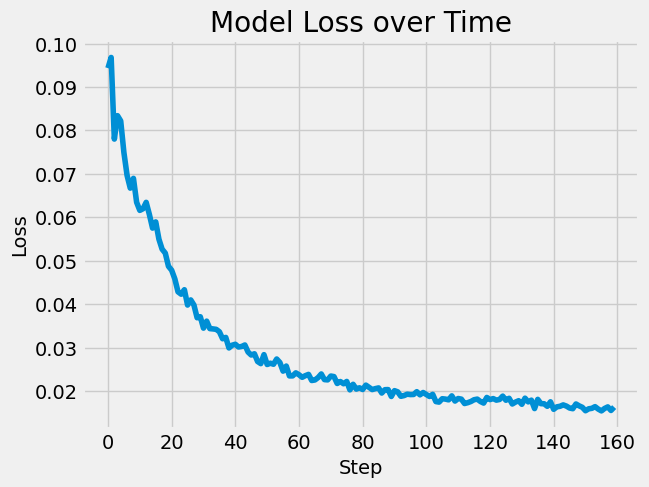

In [13]:
plt.plot(losses)
plt.title("Model Loss over Time")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

#### Sampling

Denoising an image at once is a very hard task. Instead, we denoise over a fixed number of steps and obtain our final generated sample. At each step, a certain portion of the noise is removed and with more steps, the generated sample looks more and more like an actual sample from the MNIST training samples.

In [14]:
gen_size = 25
noise = tf.convert_to_tensor(np.full((gen_size,), 0.5, dtype=np.float32))
x = add_noise(x_train[:gen_size], noise)
step_history = [x]
prediction_history = []

for i in range(time_steps):
    prediction = model(x)
    mix_factor = 1 / (time_steps - i)
    x = x * (1 - mix_factor) + prediction * mix_factor
    x = tf.clip_by_value(x, 0, 1)
    step_history.append(x)
    prediction_history.append(prediction)

step_history = np.array(step_history)
prediction_history = np.array(prediction_history)

#### Visualization

Plot of generated samples

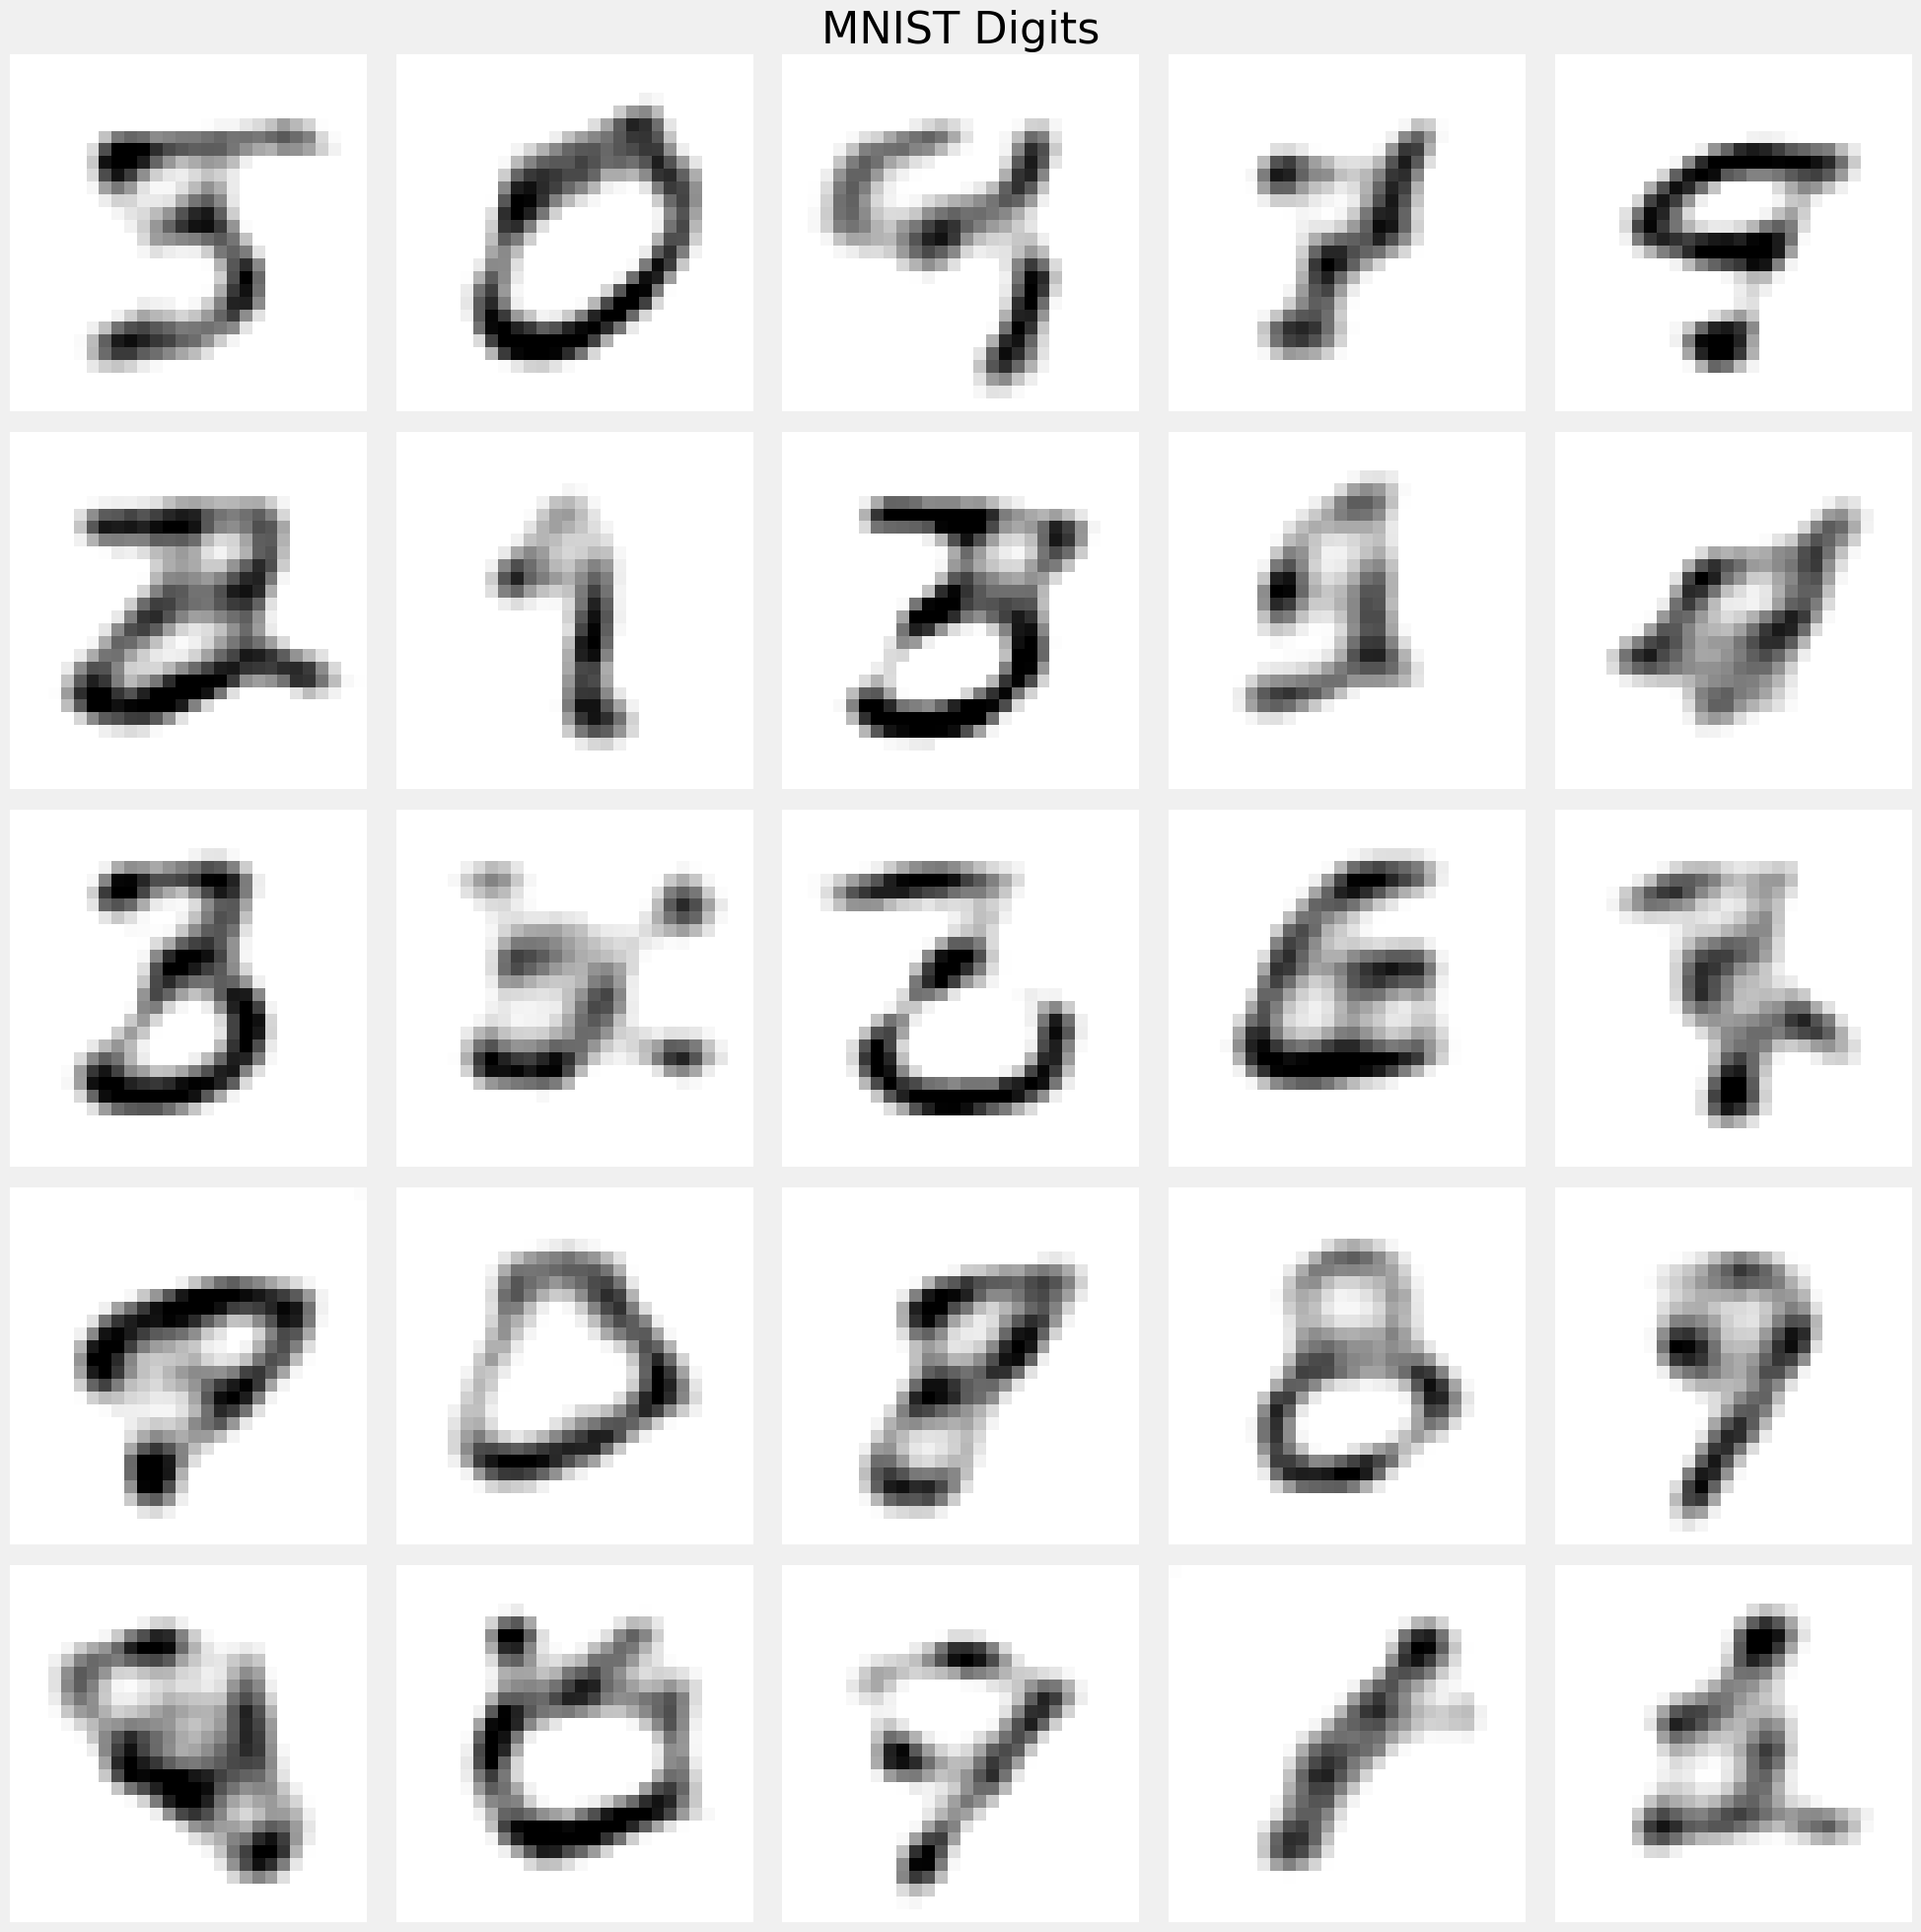

In [15]:
display_samples(x)

Video of noise removal process from different generated samples over time

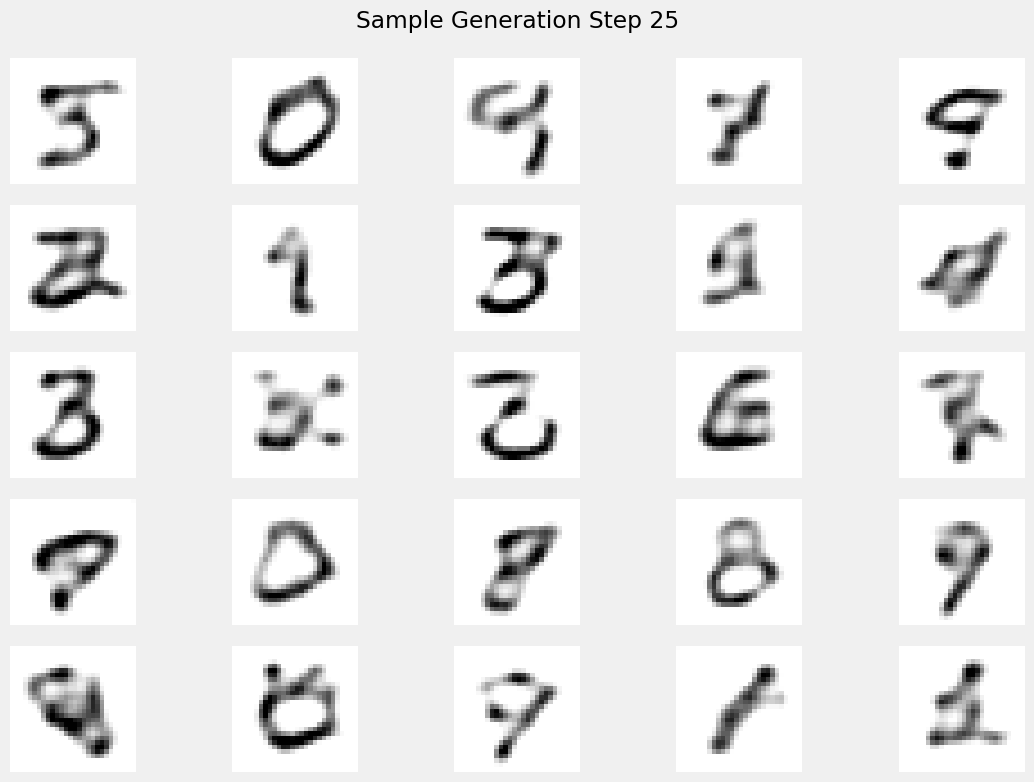

In [16]:
# Final result omitted here to make plot fit the grid perfectly
plot_sample_generation(step_history)